# Analysis

Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

## Experiment 1: Delay test 1


Test setup: connect 2 devices in normal operation mode, both free to rotate on table.

![Image of the setup](assets/exp1_setup.png "Image of the setup")

We press activation button at the same time and record the positions at 33Hz. We can then plot the data and analyse the delay between the leader and the follower.

Caveats:
- Human error when "simultaneously" pressing the button
- Serial delay not taken into account (although both are transmitting through serial at the same baudrate, so idk) 



Loading the experiment data

In [2]:
experiment_id = 2

In [3]:
leader_df = pd.read_csv(f"data/experiment{experiment_id}/leader.txt", header=None).rename(columns={0: "leader"})
leader_df.describe()

,leader
count,2097.000000
mean,0.736733
std,0.286270
min,0.000000
25%,0.542404
50%,0.838770
75%,1.000000
max,1.000000


In [4]:
follower_df = pd.read_csv(f"data/experiment{experiment_id}/follower.txt", header=None).rename(columns={0: "follower"})

def mapRange(x, in_min, in_max, out_min, out_max):
  return abs(x - in_min) * abs(out_max - out_min) / abs(in_max - in_min) + out_min;s

# scale the follower data to a [0, 1] range
follower_df["follower"] = follower_df["follower"].apply(lambda x: mapRange(x, follower_df["follower"].min(), follower_df["follower"].max(), 0, 1))
follower_df.describe()

,follower
count,2035.000000
mean,0.709571
std,0.276995
min,0.000000
25%,0.524509
50%,0.801577
75%,0.964731
max,1.000000


In [9]:
import datetime


all_df = pd.concat([leader_df, follower_df], axis=1)

# Transform the index into a time series, each index is 30ms
period = 30 # ms
all_df.insert(0, "time", all_df.index * period)

# Remove nan values
all_df.dropna(inplace=True)

all_df.head()

,time,leader,follower
0,0,1.0,0.968045
1,30,1.0,0.967585
2,60,1.0,0.968376
3,90,1.0,0.968045
4,120,1.0,0.967782


In [10]:
# Time delay analysis
# using https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlation_lags.html#scipy.signal.correlation_lags

leader_signal = all_df["leader"].to_numpy()
follower_signal = all_df["follower"].to_numpy()

# Filter the signals
leader_signal = signal.savgol_filter(leader_signal, 30, 3)
follower_signal = signal.savgol_filter(follower_signal, 30, 3)

all_df["leader"] = leader_signal
all_df["follower"] = follower_signal

correlation = signal.correlate(leader_signal, follower_signal, mode="full")

lags = signal.correlation_lags(leader_signal.size, follower_signal.size, mode="full")
lag = lags[np.argmax(correlation)]
time_delay = abs(lag * period)
print(f"Estimated time delay: {time_delay}ms")

Estimated time delay: 0ms


In [11]:
all_df["time"] = all_df["time"]/1000
all_df

,time,leader,follower
0,0.00,1.000221,0.967939
1,0.03,0.997089,0.967932
2,0.06,0.994545,0.967925
3,0.09,0.992547,0.967919
4,0.12,0.991053,0.967914
...,...,...,...
2030,60.90,0.996595,0.965114
2031,60.93,0.996646,0.965099
2032,60.96,0.996624,0.965080
2033,60.99,0.996520,0.965056


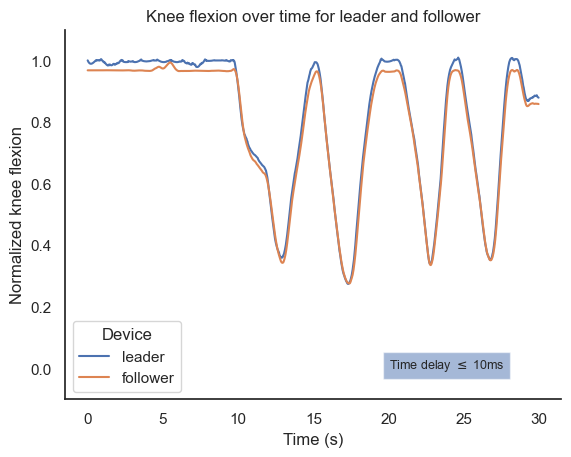

In [14]:
sns.set_theme(style="white")
sns.lineplot(
    x="time",
    y="value",
    hue="variable",
    data=pd.melt(all_df[:1000], ["time"]),
)
sns.despine()

plt.title("Knee flexion over time for leader and follower")
plt.ylabel("Normalized knee flexion")
plt.ylim(-0.1, 1.1)
plt.xlabel("Time (s)")
plt.legend(title="Device")

plt.text(20, 0, f"Time delay $\\leq$ {10}ms", fontsize = 9,  
         bbox = dict(alpha = 0.5)) 

plt.savefig(f"results/experiment{experiment_id}.png", dpi=300)
plt.show()